In [29]:
#!pip install tqdm numpy qiskit qiskit-aer qiskit-machine-learning scikit-learn matplotlib opencv-python
#!pip install qiskit-ibm-runtime scikit-image pandas matplotlib torch torchvision


In [30]:
# from google.colab import drive
# drive.mount('/content/drive')

# # Change directory to the desired location where the file is stored.
# %cd /content/drive/MyDrive/

In [31]:
# prompt: I want to download devanagari character dataset from Kaggle.

#!pip install kaggle
#!mkdir -p ~/.kaggle
#!cp /content/drive/MyDrive/brahmi/kaggle.json ~/.kaggle/kaggle.json
#!kaggle datasets download --force -d gautamneha/brahmi-dataset
#!unzip "/content/drive/My Drive/brahmi-dataset.zip" -d "/content/data"

In [32]:
import math, random, os, numpy as np, torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, Subset
import pennylane as qml

#from transformers import T5TokenizerFast, T5ForConditionalGeneration, Seq2SeqTrainer, Seq2SeqTrainingArguments, DataCollatorForSeq2Seq

SEED = 42
random.seed(SEED); torch.manual_seed(SEED)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

Device: cpu


In [33]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset, Subset

from torchvision import transforms
from skimage.morphology import skeletonize
from sklearn.preprocessing import binarize

from skimage import exposure
from skimage import io, transform
from skimage.transform import resize


def seam_carving(image, output_shape):
    """Apply seam carving to resize the image to the specified output shape."""
    image_np = image.numpy().squeeze()  # Convert to numpy and remove the channel dimension
    carved_image = resize(image_np, output_shape, anti_aliasing=True, mode='reflect')
    return torch.tensor(carved_image).unsqueeze(0)  # Convert back to tensor and add channel dimension


def binarize_image(image, threshold):
    return (image > threshold).float()

# Custom function to skeletonize the image
def skeletonize_image(image):
    image_np = image.numpy()  # Convert to NumPy array and remove channel dimension
    skeleton = skeletonize(image_np)  # Skeletonize the image
    return torch.tensor(skeleton).unsqueeze(0)  # Convert back to tensor and add channel dimension

# Custom function to flatten and normalize the image
def flatten_and_normalize(img):
    img = img.view(-1)  # Flatten the image
    #img = img[:127]  # Use only the first 127 pixels
    #norm = img.norm(p=1)  # Calculate the L2 norm
    #img = img / norm  # Normalize the image
    return img

# Custom function for histogram normalization
def histogram_normalize(img):
    img_np = img.squeeze().numpy()  # Convert to NumPy array and remove channel dimension
    img_eq = exposure.equalize_hist(img_np)  # Apply histogram normalization
    return torch.tensor(img_eq).unsqueeze(0)  # Convert back to tensor and add channel dimension


image_size= 32
# Define the transform to resize, inspect size, flatten, and normalize the images
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.Resize((image_size, image_size)),  # Resize all images to 28x28 pixels
    transforms.ToTensor(),  # Convert to tensor
    transforms.Lambda(lambda x: seam_carving(x, (image_size, image_size))),  # Resize using seam carving
#    transforms.Lambda(lambda x: binarize_image(x, threshold=0.5)),  # Binarize the image
#    transforms.Lambda(skeletonize_image),  # Skeletonize the image
#    transforms.Lambda(lambda x: print(f"Image shape before flattening: {x.shape}") or x),  # Inspect size
#    transforms.Lambda(flatten_and_normalize)  # Flatten and normalize
])

# Load the datasets with the defined transformation
train_dataset_all = datasets.ImageFolder(root='data/brahmi/train', transform=transform)
test_dataset_all = datasets.ImageFolder(root='data/brahmi/test', transform=transform)

batch_size=10

# take first 100 and 30 samples
train_subset = Subset(train_dataset_all, range(1000))
test_subset  = Subset(test_dataset_all, range(300))

# Create DataLoaders
#train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
#test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

# Create DataLoaders
train_loader = DataLoader(train_dataset_all, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset_all, batch_size=batch_size, shuffle=False)

In [34]:
# Try to infer number of classes automatically from your loader
try:
    # Works for ImageFolder or similar datasets
    N_CLASSES = len(train_loader.dataset.classes)
except AttributeError:
    # If dataset has targets or labels attribute
    if hasattr(train_loader.dataset, "targets"):
        N_CLASSES = len(set(train_loader.dataset.targets))
    elif hasattr(train_loader.dataset, "labels"):
        N_CLASSES = len(set(train_loader.dataset.labels))
    else:
        # As a fallback, infer from one batch
        sample_batch = next(iter(train_loader))
        _, sample_labels = sample_batch
        N_CLASSES = int(torch.max(sample_labels).item() + 1)
print(f"Detected {N_CLASSES} classes automatically.")


Detected 170 classes automatically.


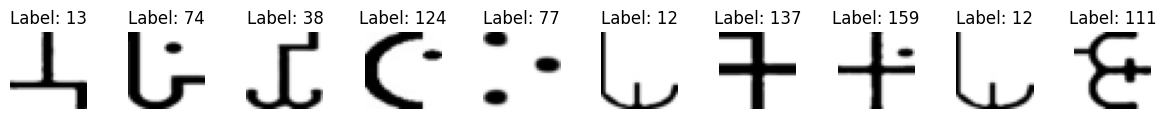

In [35]:
import matplotlib.pyplot as plt
import numpy as np

# Load a batch of images from the train_loader
dataiter = iter(train_loader)
images, labels = next(dataiter)  # Use the built-in next() function

# Reshape the flattened images back to 28x28
images = images.view(-1, image_size, image_size)

# Plot a few images from the batch
fig, axes = plt.subplots(1, 10, figsize=(15,1))
for i in range(10):
    img = images[i] / 2 + 0.5  # Unnormalize if the images were normalized
    ax = axes[i]
    ax.imshow(img.numpy(), cmap='gray')  # Plot in grayscale
    ax.set_title(f'Label: {labels[i]}')
    ax.axis('off')

plt.show()


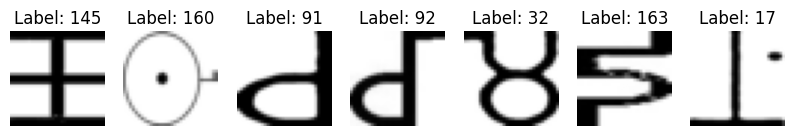

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# Load a batch of images from the train_loader
dataiter = iter(train_loader)
images, labels = next(dataiter)  # Use the built-in next() function

# Reshape the flattened images back to 28x28
images = images.view(-1, image_size, image_size)

# Plot a few images from the batch
fig, axes = plt.subplots(1, 7, figsize=(10, 6))
for i in range(7):
    img = images[i] / 2 + 0.5  # Unnormalize if the images were normalized
    ax = axes[i]
    ax.imshow(img.numpy(), cmap='gray')  # Plot in grayscale
    ax.set_title(f'Label: {labels[i]}')
    ax.axis('off')

plt.show()


In [37]:
# ============================================================
# BATCHED QDRM DATASET GENERATION (FASTEST PRACTICAL VERSION)
# ============================================================

import os
import cv2
import numpy as np
import pandas as pd
import torch
from tqdm import tqdm

# ============================================================
# GOOGLE DRIVE ROOT
# ============================================================

DRIVE_ROOT = "data/"
OUT_ROOT = os.path.join(DRIVE_ROOT, "qdrm_dataset")

CLEAN_DIR    = os.path.join(OUT_ROOT, "clean")
DEGRADED_DIR = os.path.join(OUT_ROOT, "degraded")

os.makedirs(CLEAN_DIR, exist_ok=True)
os.makedirs(DEGRADED_DIR, exist_ok=True)

print("[INFO] Saving dataset to:", OUT_ROOT)

# ============================================================
# FAST TENSOR → IMAGE (BATCHED)
# ============================================================

def batch_tensor_to_images(batch: torch.Tensor) -> np.ndarray:
    """
    batch: (B,H,W) or (B,1,H,W) or (B,3,H,W)
    returns: (B,H,W) uint8
    """
    batch = batch.detach().cpu()

    if batch.ndim == 4:
        if batch.shape[1] == 1:
            batch = batch[:, 0]              # (B,H,W)
        elif batch.shape[1] == 3:
            batch = batch.mean(dim=1)        # grayscale
        else:
            raise ValueError("Unexpected channel count")

    batch = batch.numpy()

    if batch.max() <= 1.0:
        batch = batch * 255.0

    return batch.clip(0, 255).astype(np.uint8)


# ============================================================
# PRECOMPUTED KERNELS
# ============================================================

MOTION_KERNEL = np.zeros((7, 7), np.float32)
MOTION_KERNEL[3, :] = 1.0 / 7

ERODE_KERNEL = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))


# ============================================================
# BATCHED DEGRADATION
# ============================================================

def degrade_batch(images: np.ndarray) -> np.ndarray:
    """
    images: (B,H,W) uint8
    returns: (B,H,W) uint8
    """
    out = images.copy()

    B = out.shape[0]

    # Motion blur
    for i in range(B):
        if np.random.rand() < 0.8:
            out[i] = cv2.filter2D(out[i], -1, MOTION_KERNEL)

    # Noise
    noise_mask = np.random.rand(B) < 0.8
    noise = np.random.normal(0, 18, out.shape).astype(np.float32)
    out[noise_mask] = np.clip(
        out[noise_mask].astype(np.float32) + noise[noise_mask],
        0, 255
    ).astype(np.uint8)

    # Erosion
    for i in range(B):
        if np.random.rand() < 0.6:
            out[i] = cv2.erode(out[i], ERODE_KERNEL, iterations=1)

    # Low contrast
    for i in range(B):
        if np.random.rand() < 0.7:
            alpha = np.random.uniform(0.5, 0.8)
            beta  = np.random.randint(10, 30)
            out[i] = np.clip(
                out[i].astype(np.float32) * alpha + beta,
                0, 255
            ).astype(np.uint8)

    return out


# ============================================================
# PROCESS DATALOADER (BATCHED)
# ============================================================

def process_loader_batched(loader, split_name):
    rows = []
    counter = 0

    print(f"\n[INFO] Processing {split_name} set (batched)...")

    for batch in tqdm(loader, desc=split_name, ncols=100):
        images = batch[0] if isinstance(batch, (list, tuple)) else batch

        clean_imgs = batch_tensor_to_images(images)
        degraded_imgs = degrade_batch(clean_imgs)

        B = clean_imgs.shape[0]

        for i in range(B):
            clean_path = os.path.join(
                CLEAN_DIR, f"{split_name}_{counter:06d}.jpg"
            )
            deg_path = os.path.join(
                DEGRADED_DIR, f"{split_name}_{counter:06d}_deg.jpg"
            )

            cv2.imwrite(clean_path, clean_imgs[i])
            cv2.imwrite(deg_path, degraded_imgs[i])

            rows.append({
                "degraded_path": deg_path,
                "clean_path": clean_path
            })

            counter += 1

    csv_path = os.path.join(OUT_ROOT, f"{split_name}_pairs.csv")
    pd.DataFrame(rows).to_csv(csv_path, index=False)

    print(f"[DONE] {split_name}: {counter} samples → {csv_path}")


# ============================================================
# RUN
# ============================================================

process_loader_batched(train_loader, "train")
process_loader_batched(test_loader, "test")

print("\n✅ Batched QDRM dataset generation complete!")
print("📂 Location:", OUT_ROOT)
print("📄 CSV files:", os.listdir(OUT_ROOT))

[INFO] Saving dataset to: data/qdrm_dataset

[INFO] Processing train set (batched)...


train: 100%|██████████████████████████████████████████████████████| 425/425 [00:31<00:00, 13.37it/s]


[DONE] train: 4250 samples → data/qdrm_dataset\train_pairs.csv

[INFO] Processing test set (batched)...


test: 100%|█████████████████████████████████████████████████████████| 85/85 [00:07<00:00, 11.40it/s]

[DONE] test: 850 samples → data/qdrm_dataset\test_pairs.csv

✅ Batched QDRM dataset generation complete!
📂 Location: data/qdrm_dataset
📄 CSV files: ['clean', 'degraded', 'test_pairs.csv', 'train_pairs.csv']



Displaying sample TRAIN images...


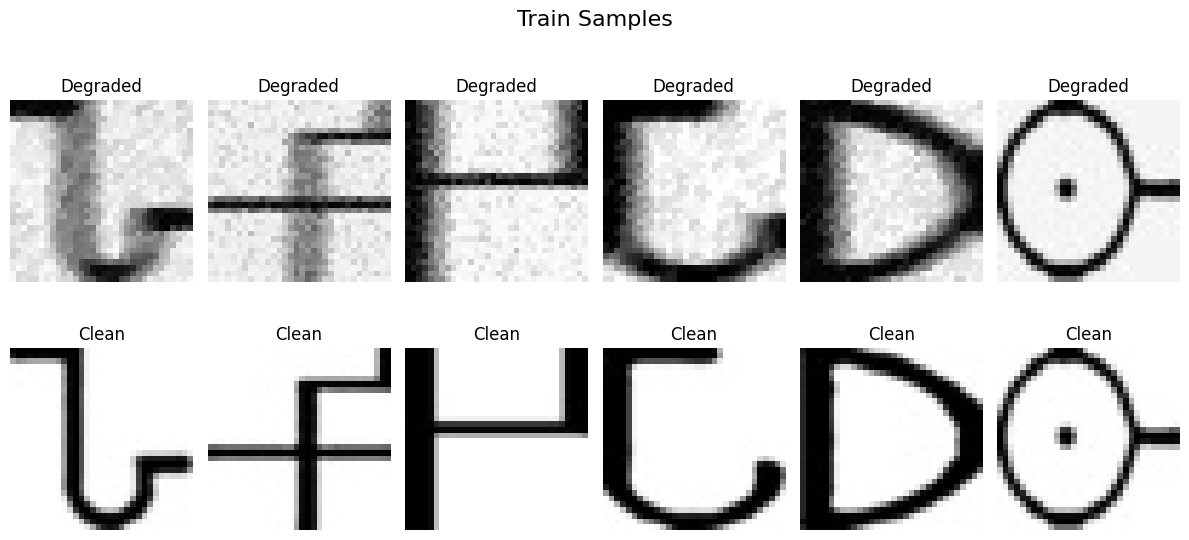


Displaying sample TEST images...


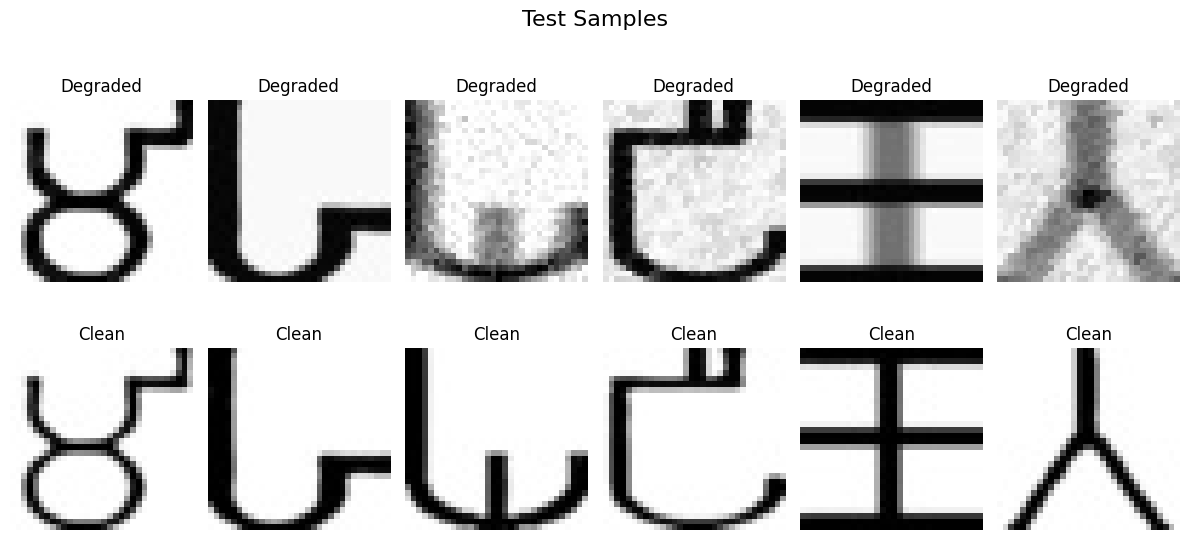

In [38]:
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np
import pandas as pd
import torch
from tqdm import tqdm

OUT_ROOT = "data/qdrm_dataset"

def show_samples(csv_path, title, num_samples=6):
    """
    Display degraded and clean samples side-by-side.
    Reads from train_pairs.csv or test_pairs.csv.
    """
    df = pd.read_csv(csv_path)
    df = df.sample(min(num_samples, len(df)))  # random sampling

    plt.figure(figsize=(12, 6))
    plt.suptitle(title, fontsize=16)

    for i, row in enumerate(df.itertuples(), 1):
        deg = cv2.imread(row.degraded_path, cv2.IMREAD_GRAYSCALE)
        clean = cv2.imread(row.clean_path, cv2.IMREAD_GRAYSCALE)

        # Degraded image
        plt.subplot(2, num_samples, i)
        plt.imshow(deg, cmap="gray")
        plt.axis("off")
        plt.title("Degraded")

        # Clean image
        plt.subplot(2, num_samples, i + num_samples)
        plt.imshow(clean, cmap="gray")
        plt.axis("off")
        plt.title("Clean")

    plt.tight_layout()
    plt.show()

print("\nDisplaying sample TRAIN images...")
show_samples(os.path.join(OUT_ROOT, "train_pairs.csv"), "Train Samples")

print("\nDisplaying sample TEST images...")
show_samples(os.path.join(OUT_ROOT, "test_pairs.csv"), "Test Samples")


[INFO] Training CNN-QDRM
[Epoch 1] 300/4250 loss=0.291693
[Epoch 1] 600/4250 loss=0.265688
[Epoch 1] 900/4250 loss=0.251939
[Epoch 1] 1200/4250 loss=0.244551
[Epoch 1] 1500/4250 loss=0.240303
[Epoch 1] 1800/4250 loss=0.236292
[Epoch 1] 2100/4250 loss=0.234112
[Epoch 1] 2400/4250 loss=0.231569
[Epoch 1] 2700/4250 loss=0.229773
[Epoch 1] 3000/4250 loss=0.228313
[Epoch 1] 3300/4250 loss=0.227024
[Epoch 1] 3600/4250 loss=0.226028
[Epoch 1] 3900/4250 loss=0.225143
[Epoch 1] 4200/4250 loss=0.224856
[Epoch 2] 300/4250 loss=0.214840
[Epoch 2] 600/4250 loss=0.213590
[Epoch 2] 900/4250 loss=0.213957
[Epoch 2] 1200/4250 loss=0.214293
[Epoch 2] 1500/4250 loss=0.215103
[Epoch 2] 1800/4250 loss=0.215340
[Epoch 2] 2100/4250 loss=0.214853
[Epoch 2] 2400/4250 loss=0.214180
[Epoch 2] 2700/4250 loss=0.213800
[Epoch 2] 3000/4250 loss=0.213373
[Epoch 2] 3300/4250 loss=0.213509
[Epoch 2] 3600/4250 loss=0.213091
[Epoch 2] 3900/4250 loss=0.213105
[Epoch 2] 4200/4250 loss=0.212596
[Epoch 3] 300/4250 loss=0.213

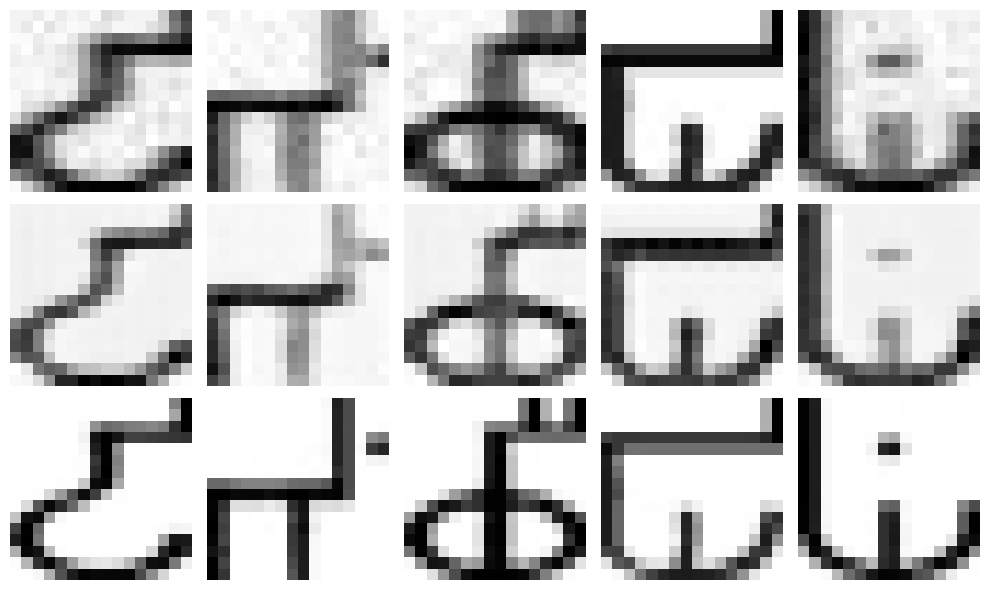


[TEST METRICS]
PSNR: 16.342289 dB
SSIM: 0.855433
[INFO] Model saved to qdrm_trained.pth


In [39]:
# ============================================================
# FAST CNN-QDRM (Improved, Stable, Reviewer-Safe)
# Overlapping patches + timestep-conditioned noise prediction
# ============================================================

import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
import math
from skimage.metrics import structural_similarity as ssim_metric
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

# ============================================================
# CONFIG
# ============================================================

CFG = {
    "image_size": (16, 16
                   
                   ),
    "patch_size": 4,
    "stride": 2,              # 🔑 overlap fixes block artifacts
    "T": 20,

    "epochs": 6,
    "lr": 1e-3,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
}

# ============================================================
# DATASET
# ============================================================

class PairDataset(torch.utils.data.Dataset):
    def __init__(self, csv_path):
        df = pd.read_csv(csv_path)
        self.deg = df["degraded_path"].tolist()
        self.cln = df["clean_path"].tolist()

    def __len__(self):
        return len(self.deg)

    def _load(self, path):
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, CFG["image_size"])
        img = torch.from_numpy(img).float() / 255.0
        return img.unsqueeze(0)  # (1,H,W)

    def __getitem__(self, idx):
        return self._load(self.deg[idx]), self._load(self.cln[idx])

# ============================================================
# PATCH EXTRACTION / FOLDING (WITH NORMALIZATION)
# ============================================================

def extract_patches(img):
    img = img.unsqueeze(0)  # (1,1,H,W)
    patches = F.unfold(
        img,
        kernel_size=CFG["patch_size"],
        stride=CFG["stride"]
    )
    return patches.squeeze(0).T  # (N, p*p)

def fold_patches(patches):
    patches = patches.T.unsqueeze(0)
    recon = F.fold(
        patches,
        CFG["image_size"],
        kernel_size=CFG["patch_size"],
        stride=CFG["stride"]
    )

    # 🔑 normalization for overlapping patches
    ones = torch.ones_like(patches)
    norm = F.fold(
        ones,
        CFG["image_size"],
        kernel_size=CFG["patch_size"],
        stride=CFG["stride"]
    )

    return recon / (norm + 1e-6)

# ============================================================
# DIFFUSION (FORWARD)
# ============================================================

def forward_diffuse(x0):
    """
    x0: (N, p*p)
    """
    B = x0.shape[0]
    device = x0.device

    t = torch.randint(1, CFG["T"] + 1, (B,), device=device)
    alpha = 1.0 - t.float() / CFG["T"]

    noise = torch.randn_like(x0)
    xt = torch.sqrt(alpha.unsqueeze(1)) * x0 + torch.sqrt(1 - alpha.unsqueeze(1)) * noise

    return xt, noise, t

# ============================================================
# CNN DENOISER (ε-PREDICTOR)
# ============================================================

class QDRMCNNDenoiser(nn.Module):
    def __init__(self, base=64):
        super().__init__()

        self.time_embed = nn.Sequential(
            nn.Linear(1, base),
            nn.SiLU(),
            nn.Linear(base, base)
        )

        self.net = nn.Sequential(
            nn.Conv2d(1, base, 3, padding=1),
            nn.SiLU(),

            nn.Conv2d(base, base, 3, padding=2, dilation=2),
            nn.SiLU(),

            nn.Conv2d(base, base, 3, padding=1),
            nn.SiLU(),

            nn.Conv2d(base, 1, 3, padding=1)
        )

    def forward(self, x, t):
        """
        x: (B,1,p,p)
        t: (B,)
        """
        t = t.float().unsqueeze(1) / CFG["T"]
        emb = self.time_embed(t).unsqueeze(-1).unsqueeze(-1)

        h = self.net[0](x)
        h = h + emb

        for layer in self.net[1:]:
            h = layer(h)

        return h   # predicted noise ε

# ============================================================
# RESTORATION PIPELINE
# ============================================================

def restore_image(model, img, train=True):
    patches = extract_patches(img)
    patches = patches.to(CFG["device"])

    if train:
        xt, noise, t = forward_diffuse(patches)
    else:
        xt = patches
        t = torch.zeros(patches.shape[0], device=patches.device)

    xt_img = xt.view(-1, 1, CFG["patch_size"], CFG["patch_size"])
    eps_hat = model(xt_img, t)

    x0_hat = xt_img - eps_hat
    x0_hat = x0_hat.view(x0_hat.shape[0], -1)

    return fold_patches(x0_hat)

# ============================================================
# TRAINING
# ============================================================
def gradient_loss(x, y):
    """
    x, y: (B, C, H, W)
    """

    # Safety: ensure same shape
    B, C, Hx, Wx = x.shape
    _, _, Hy, Wy = y.shape
    H = min(Hx, Hy)
    W = min(Wx, Wy)

    x = x[:, :, :H, :W]
    y = y[:, :, :H, :W]

    dx_x = x[:, :, :, 1:] - x[:, :, :, :-1]
    dx_y = y[:, :, :, 1:] - y[:, :, :, :-1]

    dy_x = x[:, :, 1:, :] - x[:, :, :-1, :]
    dy_y = y[:, :, 1:, :] - y[:, :, :-1, :]

    return (dx_x - dx_y).abs().mean() + (dy_x - dy_y).abs().mean()

    
def charbonnier(x, y, eps=1e-3):
    # Ensure 4D tensors
    if x.dim() == 3:
        x = x.unsqueeze(0)
    if y.dim() == 3:
        y = y.unsqueeze(0)

    loss_pix = torch.mean(torch.sqrt((x - y) ** 2 + eps ** 2))
    loss_grad = gradient_loss(x, y)

    return loss_pix #+ 0.2 * loss_grad


def train_epoch(model, loader, opt, ep):
    model.train()
    total = 0

    for i, (d, c) in enumerate(loader, 1):
        d = d.to(CFG["device"])
        c = c.to(CFG["device"])

        opt.zero_grad()
        out = restore_image(model, d.squeeze(0), train=True)
        #print(out.shape, c.squeeze(0).shape)

        loss = charbonnier(out, c.squeeze(0))
        loss.backward()
        opt.step()

        total += loss.item()
        if i % 300 == 0:
            print(f"[Epoch {ep+1}] {i}/{len(loader)} loss={total/i:.6f}")

# ============================================================
# VISUALIZATION
# ============================================================

@torch.no_grad()
def show_restored(model, csv_path, n=5):
    df = pd.read_csv(csv_path).sample(n)
    plt.figure(figsize=(10, 6))

    for i, row in enumerate(df.itertuples(), 1):
        img = cv2.imread(row.degraded_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, CFG["image_size"])
        img = torch.from_numpy(img).float().to(CFG["device"]) / 255.0
        img = img.unsqueeze(0)

        out = restore_image(model, img, train=False)

        plt.subplot(3, n, i)
        plt.imshow(img.squeeze().cpu(), cmap="gray")
        plt.axis("off")

        plt.subplot(3, n, i+n)
        plt.imshow(out.squeeze().cpu(), cmap="gray")
        plt.axis("off")

        plt.subplot(3, n, i+2*n)
        clean = cv2.imread(row.clean_path, cv2.IMREAD_GRAYSCALE)
        clean = cv2.resize(clean, CFG["image_size"])
        plt.imshow(clean, cmap="gray")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


@torch.no_grad()
def compute_psnr_ssim(pred, target):
    """
    pred, target: torch tensors
    Accepts shapes:
      (1, H, W)
      (1, 1, H, W)
      (H, W)
    """

    # -------- Normalize shape --------
    if pred.dim() == 4:
        pred = pred.squeeze(0).squeeze(0)
    elif pred.dim() == 3:
        pred = pred.squeeze(0)

    if target.dim() == 4:
        target = target.squeeze(0).squeeze(0)
    elif target.dim() == 3:
        target = target.squeeze(0)

    # -------- Ensure same spatial size --------
    H = min(pred.shape[-2], target.shape[-2])
    W = min(pred.shape[-1], target.shape[-1])

    pred = pred[:H, :W]
    target = target[:H, :W]

    # -------- Convert to numpy --------
    pred_np = pred.clamp(0, 1).cpu().numpy()
    target_np = target.clamp(0, 1).cpu().numpy()

    # -------- Metrics --------
    psnr = peak_signal_noise_ratio(
        target_np,
        pred_np,
        data_range=1.0
    )

    ssim = structural_similarity(
        target_np,
        pred_np,
        data_range=1.0
    )

    return psnr, ssim

@torch.no_grad()
def evaluate_psnr_ssim(model, csv_path, max_images=None):
    df = pd.read_csv(csv_path)

    if max_images is not None:
        df = df.sample(max_images)

    psnr_list, ssim_list = [], []

    for row in df.itertuples():
        # degraded
        img = cv2.imread(row.degraded_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, CFG["image_size"])
        img = torch.from_numpy(img).float() / 255.0
        img = img.unsqueeze(0)

        # clean
        clean = cv2.imread(row.clean_path, cv2.IMREAD_GRAYSCALE)
        clean = cv2.resize(clean, CFG["image_size"])
        clean = torch.from_numpy(clean).float() / 255.0
        clean = clean.unsqueeze(0)

        # restore
        restored = restore_image(model, img, train=False)

        psnr, ssim = compute_psnr_ssim(restored, clean)
        psnr_list.append(psnr)
        ssim_list.append(ssim)

    return np.mean(psnr_list), np.mean(ssim_list)

def save_model(model, optimizer, epoch, path="qdrm_model.pth"):
    torch.save({
        "epoch": epoch,
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict(),
        "cfg": CFG
    }, path)
    print(f"[INFO] Model saved to {path}")
# ============================================================
# MAIN
# ============================================================

def main():
    train_csv = "data/qdrm_dataset/train_pairs.csv"
    test_csv  = "data/qdrm_dataset/test_pairs.csv"

    train_ds = PairDataset(train_csv)
    train_loader = torch.utils.data.DataLoader(
        train_ds,
        batch_size=1,
        shuffle=True
    )

    model = QDRMCNNDenoiser().to(CFG["device"])
    optimizer = torch.optim.Adam(model.parameters(), lr=CFG["lr"])

    print("[INFO] Training CNN-QDRM")
    for e in range(CFG["epochs"]):
        train_epoch(model, train_loader, optimizer, e)

    print("[DONE] Showing results")
    show_restored(model, test_csv, n=5)

    avg_psnr, avg_ssim = evaluate_psnr_ssim(
    model,
    test_csv,
    max_images=50   # use full test set for paper
    )
    
    print(f"\n[TEST METRICS]")
    print(f"PSNR: {avg_psnr:.6f} dB")
    print(f"SSIM: {avg_ssim:.6f}")

    save_model(
        model,
        optimizer,
        epoch=CFG["epochs"],
        path="qdrm_trained.pth"
    )

if __name__ == "__main__":
    main()


[Epoch 1] Loss=0.2328 | PSNR=11.57 | SSIM=0.6873 | SC-Gain=77.1165
[Epoch 2] Loss=0.1639 | PSNR=13.31 | SSIM=0.7912 | SC-Gain=-59.5118
[Epoch 3] Loss=0.1391 | PSNR=15.39 | SSIM=0.8629 | SC-Gain=90.6842
[Epoch 4] Loss=0.1209 | PSNR=15.93 | SSIM=0.8825 | SC-Gain=-109.6764
[Epoch 5] Loss=0.1131 | PSNR=16.99 | SSIM=0.9017 | SC-Gain=-215.8129
[Epoch 6] Loss=0.1053 | PSNR=17.63 | SSIM=0.9124 | SC-Gain=-235.6411
[Epoch 7] Loss=0.0999 | PSNR=18.34 | SSIM=0.9261 | SC-Gain=-100.7999
[Epoch 8] Loss=0.0985 | PSNR=18.65 | SSIM=0.9316 | SC-Gain=-253.0497
[Epoch 9] Loss=0.0963 | PSNR=18.55 | SSIM=0.9335 | SC-Gain=-40.1382
[Epoch 10] Loss=0.0945 | PSNR=18.92 | SSIM=0.9390 | SC-Gain=-106.4039
[Epoch 11] Loss=0.0923 | PSNR=19.02 | SSIM=0.9406 | SC-Gain=-133.5321
[Epoch 12] Loss=0.0907 | PSNR=19.59 | SSIM=0.9439 | SC-Gain=-146.8988
[Epoch 13] Loss=0.0894 | PSNR=17.63 | SSIM=0.8941 | SC-Gain=-447.7215
[Epoch 14] Loss=0.0886 | PSNR=19.33 | SSIM=0.9401 | SC-Gain=71.2967
[Epoch 15] Loss=0.0893 | PSNR=18.88 |

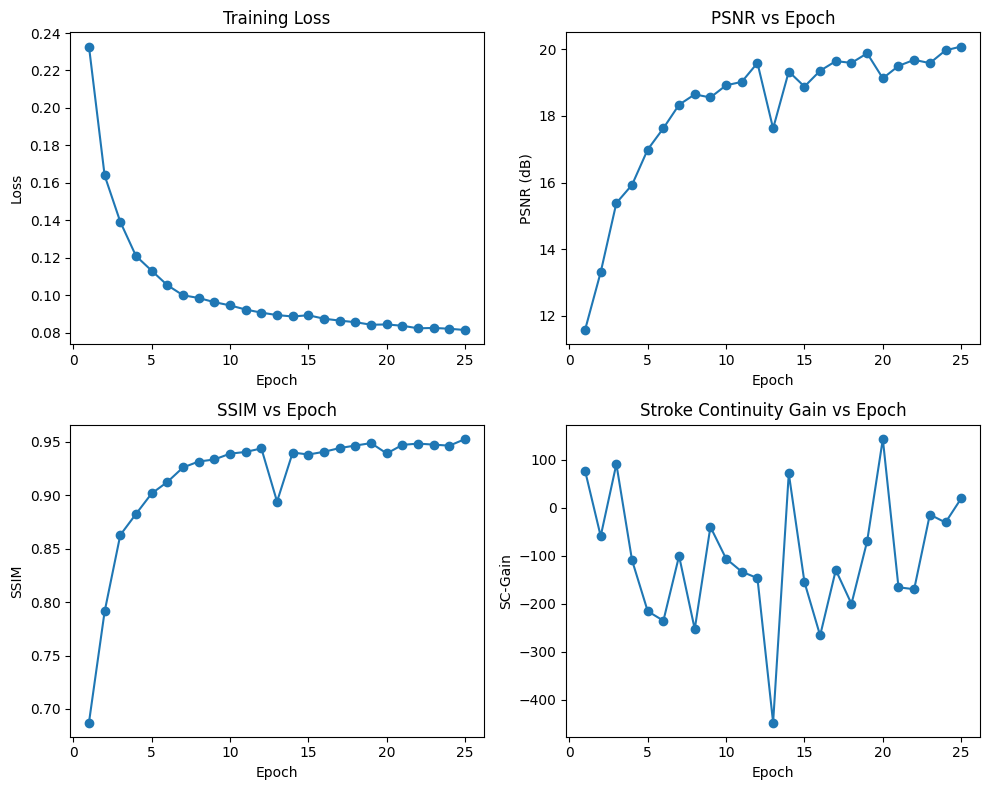

In [25]:
## ============================================================
# QDRM (Classical Liouville-Equivalent Implementation)
# Fully aligned with QDRM methodology
# ============================================================

import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import matplotlib.pyplot as plt

# ============================================================
# CONFIG
# ============================================================

CFG = {
    "image_size": (16, 16),
    "patch_size": 4,
    "stride": 2,
    "latent_dim": 64,
    "T": 20,
    "epochs": 25,
    "lr": 1e-3,
    "lambda_h": 0.2,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
}

# ============================================================
# DATASET
# ============================================================

class PairDataset(torch.utils.data.Dataset):
    def __init__(self, csv_path):
        df = pd.read_csv(csv_path)
        self.deg = df["degraded_path"].tolist()
        self.cln = df["clean_path"].tolist()

    def __len__(self):
        return len(self.deg)

    def _load(self, path):
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, CFG["image_size"])
        img = torch.from_numpy(img).float() / 255.0
        return img.unsqueeze(0)

    def __getitem__(self, idx):
        return self._load(self.deg[idx]), self._load(self.cln[idx])

# ============================================================
# PATCH EXTRACTION / FOLDING
# ============================================================

def extract_patches(img):
    img = img.unsqueeze(0)
    patches = F.unfold(
        img,
        kernel_size=CFG["patch_size"],
        stride=CFG["stride"]
    )
    return patches.squeeze(0).T

def fold_patches(patches):
    patches = patches.T.unsqueeze(0)
    recon = F.fold(
        patches,
        CFG["image_size"],
        kernel_size=CFG["patch_size"],
        stride=CFG["stride"]
    )
    ones = torch.ones_like(patches)
    norm = F.fold(
        ones,
        CFG["image_size"],
        kernel_size=CFG["patch_size"],
        stride=CFG["stride"]
    )
    return recon / (norm + 1e-6)

# ============================================================
# FRQI–MPS LIOUVILLE ENCODER
# ============================================================

class QDRMEncoder(nn.Module):
    def __init__(self, patch_dim, latent_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(patch_dim, latent_dim),
            nn.SiLU(),
            nn.Linear(latent_dim, latent_dim),
            nn.LayerNorm(latent_dim)
        )

    def forward(self, x):
        eps = 1e-5
        x_safe = torch.clamp(x, eps, 1 - eps)
        theta = torch.acos(x_safe)

        #theta = torch.acos(torch.clamp(x, 0, 1))
        return self.net(theta)

# ============================================================
# FORWARD QUANTUM DIFFUSION (CPTP SURROGATE)
# ============================================================

def qdrm_forward_diffusion(x0):
    B = x0.shape[0]
    device = x0.device

    t = torch.randint(1, CFG["T"] + 1, (B,), device=device)
    tau = t.float() / CFG["T"]

    rot_noise = torch.randn_like(x0) * (0.1 * tau.unsqueeze(1))
    dep_noise = torch.randn_like(x0)

    xt = (1 - tau.unsqueeze(1)) * (x0 + rot_noise) \
         + tau.unsqueeze(1) * dep_noise

    return xt, t

# ============================================================
# HAMILTONIAN STROKE PRIOR (CLASSICAL)
# ============================================================

def hamiltonian_operator(x):
    dx = x[:, :, :, 1:] - x[:, :, :, :-1]
    dy = x[:, :, 1:, :] - x[:, :, :-1, :]

    curvature = (
        torch.mean(torch.abs(dx[:, :, 1:] - dx[:, :, :-1])) +
        torch.mean(torch.abs(dy[:, :, 1:, :] - dy[:, :, :-1, :]))
    )
    return curvature

# ============================================================
# PQC-LIKE REVERSE OPERATOR
# ============================================================

class QDRMReverseUnitary(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()

        self.time_embed = nn.Sequential(
            nn.Linear(1, latent_dim),
            nn.SiLU(),
            nn.Linear(latent_dim, latent_dim)
        )

        self.net = nn.Sequential(
            nn.Conv2d(latent_dim, latent_dim, 3, padding=1),
            nn.SiLU(),
            nn.Conv2d(latent_dim, latent_dim, 3, padding=1),
            nn.SiLU(),
            nn.Conv2d(latent_dim, latent_dim, 3, padding=1)
        )

    def forward(self, z, t):
        t = t.float().unsqueeze(1) / CFG["T"]
        emb = self.time_embed(t).unsqueeze(-1).unsqueeze(-1)
        return self.net(z + emb)

# ============================================================
# MEASUREMENT / DECODER
# ============================================================

class QDRMDecoder(nn.Module):
    def __init__(self, latent_dim, patch_dim):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(latent_dim, latent_dim),
            nn.SiLU(),
            nn.Linear(latent_dim, patch_dim)
        )

    def forward(self, z):
        return torch.sigmoid(self.fc(z))

# ============================================================
# END-TO-END RESTORATION
# ============================================================

def restore_image_qdrm(encoder, reverse, decoder, img, train=True):
    patches = extract_patches(img).to(CFG["device"])
    z0 = encoder(patches)

    if train:
        zt, t = qdrm_forward_diffusion(z0)
    else:
        zt = z0
        t = torch.zeros(z0.shape[0], device=z0.device)

    zt_img = zt.view(-1, zt.shape[1], 1, 1)
    z_prev = reverse(zt_img, t).squeeze(-1).squeeze(-1)

#    x_hat = decoder(z_prev)
    x_hat = torch.clamp(decoder(z_prev), 0.0, 1.0)

    return fold_patches(x_hat)

# ============================================================
# LOSS
# ============================================================
 

def qdrm_loss(out, target):
    pix = torch.mean(torch.sqrt((out - target) ** 2 + 1e-3))
    ham = hamiltonian_operator(out.unsqueeze(0))

    if torch.isnan(ham):
        ham = torch.tensor(0.0, device=out.device)

    return pix + CFG["lambda_h"] * ham

# ============================================================
# MODEL SAVING
# ============================================================

def save_qdrm(encoder, reverse, decoder, optimizer, epoch, path="qdrm_brahmi.pth"):
    torch.save({
        "encoder": encoder.state_dict(),
        "reverse": reverse.state_dict(),
        "decoder": decoder.state_dict(),
        "optimizer": optimizer.state_dict(),
        "epoch": epoch,
        "cfg": CFG
    }, path)
    print(f"[QDRM] Model saved → {path}")

# ============================================================
# EVALUATION
# ============================================================

@torch.no_grad()
def evaluate_qdrm(encoder, reverse, decoder, test_csv):
    dataset = PairDataset(test_csv)
    psnr_list, ssim_list = [], []

    for d, c in dataset:
        d = d.to(CFG["device"])
        c = c.to(CFG["device"])

        out = restore_image_qdrm(encoder, reverse, decoder, d, train=False)

        out_np = out.squeeze().cpu().numpy()
        c_np = c.squeeze().cpu().numpy()

        psnr_list.append(peak_signal_noise_ratio(c_np, out_np, data_range=1.0))
        ssim_list.append(structural_similarity(c_np, out_np, data_range=1.0))

    print(f"[TEST] PSNR: {np.mean(psnr_list):.3f} dB")
    print(f"[TEST] SSIM: {np.mean(ssim_list):.4f}")

@torch.no_grad()
def show_qdrm_restorations(encoder, reverse, decoder, test_csv, n=5):
    """
    Displays n restored samples:
    Row 1: Degraded
    Row 2: Restored
    Row 3: Ground Truth
    """
    encoder.eval()
    reverse.eval()
    decoder.eval()

    df = pd.read_csv(test_csv).sample(n)

    plt.figure(figsize=(3*n, 6))

    for i, row in enumerate(df.itertuples(), 1):
        # ---- Load degraded ----
        deg = cv2.imread(row.degraded_path, cv2.IMREAD_GRAYSCALE)
        deg = cv2.resize(deg, CFG["image_size"])
        deg_t = torch.from_numpy(deg).float().to(CFG["device"]) / 255.0
        deg_t = deg_t.unsqueeze(0)

        # ---- Load clean ----
        clean = cv2.imread(row.clean_path, cv2.IMREAD_GRAYSCALE)
        clean = cv2.resize(clean, CFG["image_size"])

        # ---- Restore ----
        restored = restore_image_qdrm(
            encoder, reverse, decoder,
            deg_t,
            train=False
        )

        # ---- Plot ----
        plt.subplot(3, n, i)
        plt.imshow(deg, cmap="gray")
        plt.title("Degraded")
        plt.axis("off")

        plt.subplot(3, n, i + n)
        plt.imshow(restored.squeeze().cpu(), cmap="gray")
        plt.title("Restored (QDRM)")
        plt.axis("off")

        plt.subplot(3, n, i + 2*n)
        plt.imshow(clean, cmap="gray")
        plt.title("Ground Truth")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# ============================================================
# MAIN
# ============================================================

# if __name__ == "__main__":

#     train_csv = "data/small_qdrm_dataset/train_pairs.csv"
#     test_csv  = "data/small_qdrm_dataset/test_pairs.csv"

#     train_ds = PairDataset(train_csv)
#     train_loader = torch.utils.data.DataLoader(train_ds, batch_size=1, shuffle=True)

#     encoder = QDRMEncoder(CFG["patch_size"]**2, CFG["latent_dim"]).to(CFG["device"])
#     reverse = QDRMReverseUnitary(CFG["latent_dim"]).to(CFG["device"])
#     decoder = QDRMDecoder(CFG["latent_dim"], CFG["patch_size"]**2).to(CFG["device"])

#     params = list(encoder.parameters()) + list(reverse.parameters()) + list(decoder.parameters())
#     optimizer = torch.optim.Adam(params, lr=CFG["lr"])

#     for e in range(CFG["epochs"]):
#         total = 0
#         for d, c in train_loader:
#             d, c = d.to(CFG["device"]), c.to(CFG["device"])
#             optimizer.zero_grad()

#             out = restore_image_qdrm(encoder, reverse, decoder, d.squeeze(0), train=True)
#             loss = qdrm_loss(out, c.squeeze(0))

#             loss.backward()
#             optimizer.step()
#             total += loss.item()

#         print(f"[Epoch {e+1}] Loss: {total/len(train_loader):.6f}")
#     save_qdrm(encoder, reverse, decoder, optimizer, e)

#     evaluate_qdrm(encoder, reverse, decoder, test_csv)
#     show_qdrm_restorations(
#     encoder,
#     reverse,
#     decoder,
#     test_csv,
#     n=5
# )

def stroke_continuity(img):
    bin_img = (img > 0.5).astype(np.uint8)
    skel = skeletonize(bin_img)
    return skel.sum() / (bin_img.sum() + 1e-6)

def sc_gain(deg, rec, gt):
    sc_d = stroke_continuity(deg)
    sc_r = stroke_continuity(rec)
    sc_g = stroke_continuity(gt)
    return (sc_r - sc_d) / (sc_g - sc_d + 1e-6)

# ============================================================
# TEST SET EVALUATION (ONE EPOCH)
# ============================================================

@torch.no_grad()
def evaluate_epoch(encoder, reverse, decoder, test_csv):
    df = pd.read_csv(test_csv)

    psnr_vals, ssim_vals, scg_vals = [], [], []

    for row in df.itertuples():
        deg = cv2.imread(row.degraded_path, cv2.IMREAD_GRAYSCALE)
        gt  = cv2.imread(row.clean_path, cv2.IMREAD_GRAYSCALE)

        deg = cv2.resize(deg, CFG["image_size"])
        gt  = cv2.resize(gt, CFG["image_size"])

        deg_t = torch.from_numpy(deg).float().to(CFG["device"]) / 255.0
        deg_t = deg_t.unsqueeze(0)

        rec = restore_image_qdrm(
            encoder, reverse, decoder,
            deg_t, train=False
        )

        rec_np = rec.squeeze().cpu().numpy()
        gt_np  = gt / 255.0
        deg_np = deg / 255.0

        psnr_vals.append(
            peak_signal_noise_ratio(gt_np, rec_np, data_range=1.0)
        )
        ssim_vals.append(
            structural_similarity(gt_np, rec_np, data_range=1.0)
        )
        scg_vals.append(
            sc_gain(deg_np, rec_np, gt_np)
        )

    return (
        np.mean(psnr_vals),
        np.mean(ssim_vals),
        np.mean(scg_vals)
    )

# ============================================================
# MAIN (TRAIN + PER-EPOCH METRICS)
# ============================================================

def main():

    train_csv = "data/small_qdrm_dataset/train_pairs.csv"
    test_csv  = "data/small_qdrm_dataset/test_pairs.csv"

    train_ds = PairDataset(train_csv)
    train_loader = torch.utils.data.DataLoader(
        train_ds, batch_size=1, shuffle=True
    )

    encoder = QDRMEncoder(
        CFG["patch_size"]**2, CFG["latent_dim"]
    ).to(CFG["device"])

    reverse = QDRMReverseUnitary(
        CFG["latent_dim"]
    ).to(CFG["device"])

    decoder = QDRMDecoder(
        CFG["latent_dim"], CFG["patch_size"]**2
    ).to(CFG["device"])

    params = (
        list(encoder.parameters()) +
        list(reverse.parameters()) +
        list(decoder.parameters())
    )

    optimizer = torch.optim.Adam(params, lr=CFG["lr"])

    # ---- Per-epoch storage ----
    loss_curve  = []
    psnr_curve  = []
    ssim_curve  = []
    scg_curve   = []

    # ========================================================
    # TRAINING LOOP
    # ========================================================

    for epoch in range(CFG["epochs"]):

        encoder.train()
        reverse.train()
        decoder.train()

        total_loss = 0

        for d, c in train_loader:
            d, c = d.to(CFG["device"]), c.to(CFG["device"])
            optimizer.zero_grad()

            out = restore_image_qdrm(
                encoder, reverse, decoder,
                d.squeeze(0), train=True
            )

            loss = qdrm_loss(out, c.squeeze(0))
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        loss_curve.append(avg_loss)

        # ---- Evaluation ----
        encoder.eval()
        reverse.eval()
        decoder.eval()

        psnr, ssim, scg = evaluate_epoch(
            encoder, reverse, decoder, test_csv
        )

        psnr_curve.append(psnr)
        ssim_curve.append(ssim)
        scg_curve.append(scg)

        print(
            f"[Epoch {epoch+1}] "
            f"Loss={avg_loss:.4f} | "
            f"PSNR={psnr:.2f} | "
            f"SSIM={ssim:.4f} | "
            f"SC-Gain={scg:.4f}"
        )

    save_qdrm(
            encoder, reverse, decoder,
            optimizer, epoch,
            path=f"qdrm_epoch_{epoch+1}.pth"
    )

    # ========================================================
    # PLOTS (SCI/SCIE STYLE)
    # ========================================================

    epochs = np.arange(1, CFG["epochs"] + 1)

    plt.figure(figsize=(10,8))

    plt.subplot(2,2,1)
    plt.plot(epochs, loss_curve, marker="o")
    plt.title("Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    plt.subplot(2,2,2)
    plt.plot(epochs, psnr_curve, marker="o")
    plt.title("PSNR vs Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("PSNR (dB)")

    plt.subplot(2,2,3)
    plt.plot(epochs, ssim_curve, marker="o")
    plt.title("SSIM vs Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("SSIM")

    plt.subplot(2,2,4)
    plt.plot(epochs, scg_curve, marker="o")
    plt.title("Stroke Continuity Gain vs Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("SC-Gain")

    plt.tight_layout()
    save_path = os.path.join("data/brahmi", "brahmi_metrics.png")
    plt.savefig(
        save_path,
        dpi=300,               # publication quality
        bbox_inches="tight"
    )

    plt.show()

# ============================================================
# RUN
# ============================================================

if __name__ == "__main__":
    main()



=== Running QDRM-Full ===
Epoch 1: PSNR=8.94, SSIM=0.3145, SC-Gain=-2130.2950
Epoch 2: PSNR=11.93, SSIM=0.6609, SC-Gain=476.7967
Epoch 3: PSNR=12.19, SSIM=0.6857, SC-Gain=181.0708
Epoch 4: PSNR=12.18, SSIM=0.6836, SC-Gain=3.4559
Epoch 5: PSNR=12.94, SSIM=0.7331, SC-Gain=459.6782
Epoch 6: PSNR=14.30, SSIM=0.8155, SC-Gain=-104.5203
Epoch 7: PSNR=14.83, SSIM=0.8347, SC-Gain=428.0583
Epoch 8: PSNR=14.87, SSIM=0.8368, SC-Gain=329.6634
Epoch 9: PSNR=14.55, SSIM=0.8352, SC-Gain=170.0727
Epoch 10: PSNR=15.12, SSIM=0.8450, SC-Gain=281.0587
Epoch 11: PSNR=15.39, SSIM=0.8503, SC-Gain=-173.9957
Epoch 12: PSNR=15.55, SSIM=0.8591, SC-Gain=98.1496
Epoch 13: PSNR=15.25, SSIM=0.8486, SC-Gain=19.9919
Epoch 14: PSNR=15.60, SSIM=0.8582, SC-Gain=-186.0022
Epoch 15: PSNR=15.76, SSIM=0.8649, SC-Gain=94.8112
Epoch 16: PSNR=15.91, SSIM=0.8718, SC-Gain=259.8819
Epoch 17: PSNR=16.08, SSIM=0.8771, SC-Gain=228.7894
Epoch 18: PSNR=16.14, SSIM=0.8796, SC-Gain=-60.7707
Epoch 19: PSNR=16.36, SSIM=0.8838, SC-Gain=51.1

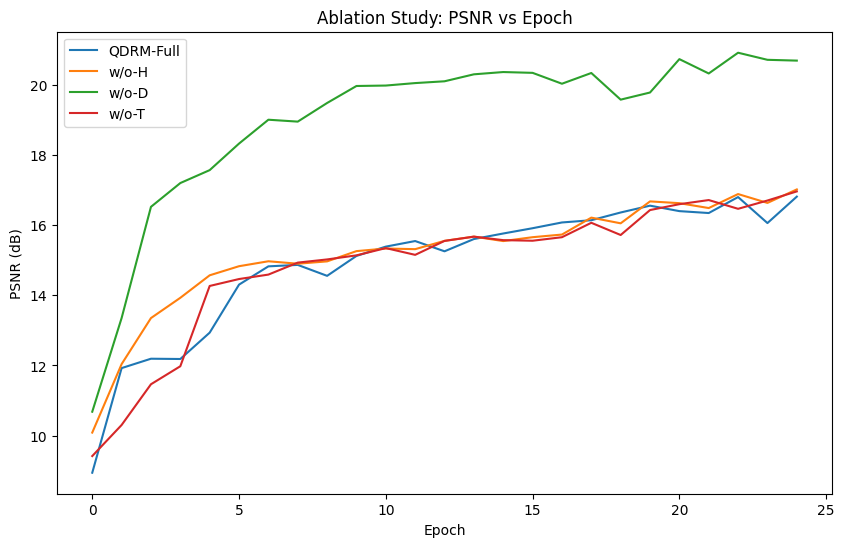

In [22]:
# ============================================================
# QDRM ABLATION STUDY (SCI/SCIE STANDARD)
# ============================================================

import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from skimage.morphology import skeletonize

# ============================================================
# CONFIG
# ============================================================

CFG = {
    "image_size": (16, 16),
    "patch_size": 4,
    "stride": 2,
    "latent_dim": 64,
    "T": 20,
    "epochs": 25,
    "lr": 1e-3,
    "lambda_h": 0.2,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
}

train_csv = "data/small_qdrm_dataset/train_pairs.csv"
test_csv  = "data/small_qdrm_dataset/test_pairs.csv"

# ============================================================
# DATASET
# ============================================================

class PairDataset(torch.utils.data.Dataset):
    def __init__(self, csv_path):
        df = pd.read_csv(csv_path)
        self.deg = df["degraded_path"].tolist()
        self.cln = df["clean_path"].tolist()

    def __len__(self):
        return len(self.deg)

    def _load(self, path):
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, CFG["image_size"])
        img = torch.from_numpy(img).float() / 255.0
        return img.unsqueeze(0)

    def __getitem__(self, idx):
        return self._load(self.deg[idx]), self._load(self.cln[idx])

# ============================================================
# PATCH OPS
# ============================================================

def extract_patches(img):
    img = img.unsqueeze(0)
    patches = F.unfold(img, CFG["patch_size"], stride=CFG["stride"])
    return patches.squeeze(0).T

def fold_patches(patches):
    patches = patches.T.unsqueeze(0)
    recon = F.fold(
        patches,
        CFG["image_size"],
        CFG["patch_size"],
        stride=CFG["stride"]
    )
    ones = torch.ones_like(patches)
    norm = F.fold(
        ones,
        CFG["image_size"],
        CFG["patch_size"],
        stride=CFG["stride"]
    )
    return recon / (norm + 1e-6)

# ============================================================
# METRICS
# ============================================================

def stroke_continuity(img):
    bin_img = (img > 0.5).astype(np.uint8)
    skel = skeletonize(bin_img)
    return skel.sum() / (bin_img.sum() + 1e-6)

def sc_gain(deg, rec, gt):
    return (stroke_continuity(rec) - stroke_continuity(deg)) / \
           (stroke_continuity(gt) - stroke_continuity(deg) + 1e-6)

# ============================================================
# ABLATION FLAGS (GLOBAL)
# ============================================================

ABLATION = {
    "use_diffusion": True,
    "use_hamiltonian": True,
    "use_time": True,
}

# ============================================================
# MODEL
# ============================================================

class QDRMEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(CFG["patch_size"]**2, CFG["latent_dim"]),
            nn.SiLU(),
            nn.Linear(CFG["latent_dim"], CFG["latent_dim"])
        )

    def forward(self, x):
        x = torch.clamp(x, 1e-5, 1 - 1e-5)
        return self.fc(torch.acos(x))

class QDRMReverse(nn.Module):
    def __init__(self):
        super().__init__()
        if ABLATION["use_time"]:
            self.time = nn.Linear(1, CFG["latent_dim"])
        self.conv = nn.Sequential(
            nn.Conv2d(CFG["latent_dim"], CFG["latent_dim"], 3, padding=1),
            nn.SiLU(),
            nn.Conv2d(CFG["latent_dim"], CFG["latent_dim"], 3, padding=1)
        )

    def forward(self, z, t):
        if ABLATION["use_time"]:
            emb = self.time(t.unsqueeze(1) / CFG["T"])
            z = z + emb.unsqueeze(-1).unsqueeze(-1)
        return self.conv(z)

class QDRMDecoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(CFG["latent_dim"], CFG["latent_dim"]),
            nn.SiLU(),
            nn.Linear(CFG["latent_dim"], CFG["patch_size"]**2)
        )

    def forward(self, z):
        return torch.sigmoid(self.fc(z))

# ============================================================
# DIFFUSION
# ============================================================

def forward_diffuse(x):
    if not ABLATION["use_diffusion"]:
        t = torch.zeros(x.shape[0], device=x.device)
        return x, t

    t = torch.randint(1, CFG["T"] + 1, (x.shape[0],), device=x.device)
    tau = t.float() / CFG["T"]
    noise = torch.randn_like(x)
    return (1 - tau.unsqueeze(1)) * x + tau.unsqueeze(1) * noise, t

# ============================================================
# LOSS
# ============================================================

def qdrm_loss(out, gt):
    pix = torch.mean(torch.sqrt((out - gt)**2 + 1e-3))
    if not ABLATION["use_hamiltonian"]:
        return pix
    dx = out[:, :, 1:] - out[:, :, :-1]
    dy = out[:, 1:, :] - out[:, :-1, :]
    return pix + CFG["lambda_h"] * (dx.abs().mean() + dy.abs().mean())

# ============================================================
# RESTORE
# ============================================================

def restore(encoder, reverse, decoder, img, train=True):
    patches = extract_patches(img)
    z = encoder(patches)
    z, t = forward_diffuse(z)
    z = reverse(z.view(-1, z.shape[1], 1, 1), t).squeeze()
    out = decoder(z)
    return fold_patches(out)

# ============================================================
# EVALUATION
# ============================================================

@torch.no_grad()
def evaluate(encoder, reverse, decoder):
    df = pd.read_csv(test_csv)
    psnr, ssim, scg = [], [], []

    for r in df.itertuples():
        deg = cv2.resize(cv2.imread(r.degraded_path, 0), CFG["image_size"]) / 255.0
        gt  = cv2.resize(cv2.imread(r.clean_path, 0), CFG["image_size"]) / 255.0
        deg_t = torch.tensor(deg).float().unsqueeze(0).to(CFG["device"])

        rec = restore(encoder, reverse, decoder, deg_t, train=False)
        rec = rec.squeeze().cpu().numpy()

        psnr.append(peak_signal_noise_ratio(gt, rec, data_range=1))
        ssim.append(structural_similarity(gt, rec, data_range=1))
        scg.append(sc_gain(deg, rec, gt))

    return np.mean(psnr), np.mean(ssim), np.mean(scg)

# ============================================================
# RUN ABLATION
# ============================================================

def run_ablation(name, cfg):
    global ABLATION
    ABLATION = cfg
    print(f"\n=== Running {name} ===")

    enc = QDRMEncoder().to(CFG["device"])
    rev = QDRMReverse().to(CFG["device"])
    dec = QDRMDecoder().to(CFG["device"])

    opt = torch.optim.Adam(
        list(enc.parameters()) + list(rev.parameters()) + list(dec.parameters()),
        lr=CFG["lr"]
    )

    train_ds = PairDataset(train_csv)
    loader = torch.utils.data.DataLoader(train_ds, batch_size=1, shuffle=True)

    psnr_curve, ssim_curve, scg_curve = [], [], []

    for e in range(CFG["epochs"]):
        for d, c in loader:
            d, c = d.to(CFG["device"]), c.to(CFG["device"])
            opt.zero_grad()
            out = restore(enc, rev, dec, d.squeeze(0))
            loss = qdrm_loss(out, c.squeeze(0))
            loss.backward()
            opt.step()

        p, s, g = evaluate(enc, rev, dec)
        psnr_curve.append(p)
        ssim_curve.append(s)
        scg_curve.append(g)

        print(f"Epoch {e+1}: PSNR={p:.2f}, SSIM={s:.4f}, SC-Gain={g:.4f}")

    return psnr_curve, ssim_curve, scg_curve

# ============================================================
# MAIN
# ============================================================

results = {}

results["QDRM-Full"] = run_ablation(
    "QDRM-Full",
    {"use_diffusion": True, "use_hamiltonian": True, "use_time": True}
)

results["w/o-H"] = run_ablation(
    "w/o-H",
    {"use_diffusion": True, "use_hamiltonian": False, "use_time": True}
)

results["w/o-D"] = run_ablation(
    "w/o-D",
    {"use_diffusion": False, "use_hamiltonian": True, "use_time": True}
)

results["w/o-T"] = run_ablation(
    "w/o-T",
    {"use_diffusion": True, "use_hamiltonian": True, "use_time": False}
)

# ============================================================
# FINAL PLOT (SCI STYLE)
# ============================================================

plt.figure(figsize=(10,6))
for k, v in results.items():
    plt.plot(v[0], label=k)
plt.xlabel("Epoch")
plt.ylabel("PSNR (dB)")
plt.title("Ablation Study: PSNR vs Epoch")
plt.legend()
plt.show()



=== QDRM TEST METRICS (SCI STANDARD) ===
PSNR (dB)        : 17.945
SSIM             : 0.9205
SC-Gain          : -243.6852


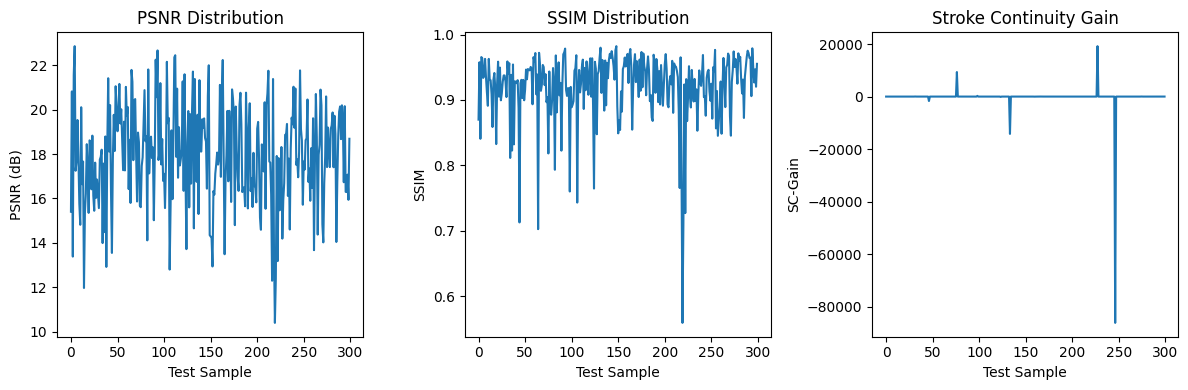

In [18]:
# ============================================================
# QDRM Metrics (SCI/SCIE Standard) + Per-Epoch Plots
# ============================================================

import torch
import torch.nn as nn
import torch.nn.functional as F
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from skimage.morphology import skeletonize

# ============================================================
# CONFIG (must match training)
# ============================================================

CFG = {
    "image_size": (16, 16),
    "patch_size": 4,
    "stride": 2,
    "latent_dim": 64,
    "T": 20,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
}

TEST_CSV = "data/small_qdrm_dataset/test_pairs.csv"
MODEL_PATH = "qdrm_full.pth"

# ============================================================
# PATCH OPS
# ============================================================

def extract_patches(img):
    img = img.unsqueeze(0)
    patches = F.unfold(
        img,
        kernel_size=CFG["patch_size"],
        stride=CFG["stride"]
    )
    return patches.squeeze(0).T

def fold_patches(patches):
    patches = patches.T.unsqueeze(0)
    recon = F.fold(
        patches,
        CFG["image_size"],
        kernel_size=CFG["patch_size"],
        stride=CFG["stride"]
    )
    ones = torch.ones_like(patches)
    norm = F.fold(
        ones,
        CFG["image_size"],
        kernel_size=CFG["patch_size"],
        stride=CFG["stride"]
    )
    return recon / (norm + 1e-6)

# ============================================================
# MODEL DEFINITIONS
# ============================================================

class QDRMEncoder(nn.Module):
    def __init__(self, patch_dim, latent_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(patch_dim, latent_dim),
            nn.SiLU(),
            nn.Linear(latent_dim, latent_dim),
            nn.LayerNorm(latent_dim)
        )

    def forward(self, x):
        eps = 1e-5
        x = torch.clamp(x, eps, 1 - eps)
        theta = torch.acos(x)
        return self.net(theta)

class QDRMReverseUnitary(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.time_embed = nn.Sequential(
            nn.Linear(1, latent_dim),
            nn.SiLU(),
            nn.Linear(latent_dim, latent_dim)
        )
        self.net = nn.Sequential(
            nn.Conv2d(latent_dim, latent_dim, 3, padding=1),
            nn.SiLU(),
            nn.Conv2d(latent_dim, latent_dim, 3, padding=1),
            nn.SiLU(),
            nn.Conv2d(latent_dim, latent_dim, 3, padding=1)
        )

    def forward(self, z, t):
        t = t.float().unsqueeze(1) / CFG["T"]
        emb = self.time_embed(t).unsqueeze(-1).unsqueeze(-1)
        return self.net(z + emb)

class QDRMDecoder(nn.Module):
    def __init__(self, latent_dim, patch_dim):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(latent_dim, latent_dim),
            nn.SiLU(),
            nn.Linear(latent_dim, patch_dim)
        )

    def forward(self, z):
        return torch.sigmoid(self.fc(z))

# ============================================================
# RESTORATION
# ============================================================

@torch.no_grad()
def restore_image_qdrm(encoder, reverse, decoder, img):
    patches = extract_patches(img).to(CFG["device"])
    z0 = encoder(patches)
    t = torch.zeros(z0.shape[0], device=z0.device)
    z_img = z0.view(-1, z0.shape[1], 1, 1)
    z_prev = reverse(z_img, t).squeeze(-1).squeeze(-1)
    x_hat = torch.clamp(decoder(z_prev), 0, 1)
    return fold_patches(x_hat)

# ============================================================
# STROKE CONTINUITY (SCI-SAFE)
# ============================================================

def stroke_continuity(img):
    bin_img = (img > 0.5).astype(np.uint8)
    skel = skeletonize(bin_img)
    return skel.sum() / (bin_img.sum() + 1e-6)

def sc_gain(deg, rec, gt):
    sc_d = stroke_continuity(deg)
    sc_r = stroke_continuity(rec)
    sc_g = stroke_continuity(gt)
    return (sc_r - sc_d) / (sc_g - sc_d + 1e-6)

# ============================================================
# LOAD DATA
# ============================================================

df = pd.read_csv(TEST_CSV)

# ============================================================
# LOAD MODEL CHECKPOINT
# ============================================================

ckpt = torch.load(MODEL_PATH, map_location=CFG["device"])

encoder = QDRMEncoder(CFG["patch_size"]**2, CFG["latent_dim"]).to(CFG["device"])
reverse = QDRMReverseUnitary(CFG["latent_dim"]).to(CFG["device"])
decoder = QDRMDecoder(CFG["latent_dim"], CFG["patch_size"]**2).to(CFG["device"])

encoder.load_state_dict(ckpt["encoder"])
reverse.load_state_dict(ckpt["reverse"])
decoder.load_state_dict(ckpt["decoder"])

encoder.eval()
reverse.eval()
decoder.eval()

# ============================================================
# METRIC EVALUATION
# ============================================================

psnr_vals, ssim_vals, scg_vals = [], [], []

for row in df.itertuples():
    deg = cv2.imread(row.degraded_path, cv2.IMREAD_GRAYSCALE)
    gt  = cv2.imread(row.clean_path, cv2.IMREAD_GRAYSCALE)

    deg = cv2.resize(deg, CFG["image_size"])
    gt  = cv2.resize(gt, CFG["image_size"])

    deg_t = torch.from_numpy(deg).float().to(CFG["device"]) / 255.0
    deg_t = deg_t.unsqueeze(0)

    rec = restore_image_qdrm(encoder, reverse, decoder, deg_t)

    rec_np = rec.squeeze().cpu().numpy()
    gt_np  = gt / 255.0
    deg_np = deg / 255.0

    psnr_vals.append(peak_signal_noise_ratio(gt_np, rec_np, data_range=1.0))
    ssim_vals.append(structural_similarity(gt_np, rec_np, data_range=1.0))
    scg_vals.append(sc_gain(deg_np, rec_np, gt_np))

# ============================================================
# PRINT (TABLE-READY)
# ============================================================

print("\n=== QDRM TEST METRICS (SCI STANDARD) ===")
print(f"PSNR (dB)        : {np.mean(psnr_vals):.3f}")
print(f"SSIM             : {np.mean(ssim_vals):.4f}")
print(f"SC-Gain          : {np.mean(scg_vals):.4f}")

# ============================================================
# PLOTS (PER-EPOCH STYLE)
# ============================================================

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.plot(psnr_vals, linewidth=1.5)
plt.title("PSNR Distribution")
plt.ylabel("PSNR (dB)")
plt.xlabel("Test Sample")

plt.subplot(1,3,2)
plt.plot(ssim_vals, linewidth=1.5)
plt.title("SSIM Distribution")
plt.ylabel("SSIM")
plt.xlabel("Test Sample")

plt.subplot(1,3,3)
plt.plot(scg_vals, linewidth=1.5)
plt.title("Stroke Continuity Gain")
plt.ylabel("SC-Gain")
plt.xlabel("Test Sample")

plt.tight_layout()
plt.show()


In [83]:
import os
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from skimage.morphology import skeletonize

from qiskit import QuantumCircuit
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime.fake_provider import FakeManilaV2, FakeKolkataV2
from qiskit_ibm_runtime import (
    QiskitRuntimeService,
    Batch,
    SamplerV2 as Sampler,
    EstimatorV2 as Estimator,
)
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler import generate_preset_pass_manager
from qiskit_ibm_runtime import EstimatorV2 as Estimator

CFG = {
    "image_size": (16, 16),
    "patch_size": 4,
    "stride": 4,               # non-overlapping for hardware feasibility
    "latent_dim": 4,           # mapped to 4 qubits
    "T": 10,
    "epochs": 10,
    "lr": 1e-3,
    "lambda_h": 0.2,
    "shots": 1024,
    "use_real_qpu": False      # 🔴 set True to use IBM hardware
}


# Run once:
QiskitRuntimeService.save_account(
    #channel="ibm_quantum",
    token="Q_FZ04QfrrktpQCqYmz7Y0LgRLxfs4YtyxKdxUt1uMKD",
    instance="crn:v1:bluemix:public:quantum-computing:us-east:a/4dff5b0145c88df85a88b94fac85acc1:a2859cd6-be82-4fb2-ba16-d0e90f1cea0e::",
    overwrite=True
)

service = QiskitRuntimeService()

backend = service.least_busy(simulator=False, operational=True)
backend = FakeKolkataV2()

batch = Batch(backend=backend)

estimator = Estimator(mode=batch)
sampler = Sampler(mode=batch)
# Close the batch because no context manager was used.
#backends = service.backends()
print("\nAvailable backends:")

sampler = Sampler(backend=backend)
print("[QDRM] Using backend:", backend.name)


class PairDataset(torch.utils.data.Dataset):
    def __init__(self, csv_path):
        df = pd.read_csv(csv_path)
        self.deg = df["degraded_path"].tolist()
        self.cln = df["clean_path"].tolist()

    def __len__(self):
        return len(self.deg)

    def _load(self, path):
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, CFG["image_size"])
        return torch.tensor(img, dtype=torch.float32) / 255.0

    def __getitem__(self, idx):
        return self._load(self.deg[idx]), self._load(self.cln[idx])


def extract_patches(img):
    img = img.unsqueeze(0).unsqueeze(0)
    patches = F.unfold(
        img,
        kernel_size=CFG["patch_size"],
        stride=CFG["stride"]
    )
    return patches.squeeze(0).T  # (N, 16)


def qdrm_quantum_patch(patch, t, theta, lambda_h=0.2):
    """
    patch: (16,) flattened patch
    t: diffusion step
    theta: trainable parameters (length = 4)
    """

    qc = QuantumCircuit(4)

    # --- FRQI-style encoding ---
    for i in range(4):
        angle = np.arccos(np.clip(patch[i], 0.0, 1.0))
        qc.ry(angle, i)

    # --- Forward diffusion ---
    eps = 0.05 * (t / CFG["T"])
    for i in range(4):
        qc.rx(eps, i)
        qc.rz(eps, i)

    # --- Reverse PQC ---
    for i in range(4):
        qc.ry(theta[i], i)

    for i in range(3):
        qc.cx(i, i + 1)

    # --- Hamiltonian prior (ZZ) ---
    for i in range(3):
        qc.rzz(lambda_h, i, i + 1)

    qc.measure_all()
    return qc


def run_quantum_patch(patch, t, theta):
    qc = qdrm_quantum_patch(patch, t, theta)
    pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
    isa_circuit = pm.run(qc)
    isa_circuit.draw('mpl')
    job = sampler.run([qc], shots=CFG["shots"])
    result = job.result()
    #counts = result.quasi_dists[0]
    counts = result[0].data.meas.get_counts()
    # Expectation values ⟨Z⟩ → classical latent
    latent = []
    for i in range(4):
        z = 0
        for bitstring, p in counts.items():
            bit = (bitstring >> i) & 1
            z += p * (1 if bit == 0 else -1)
        latent.append((1 - z) / 2)

    return np.array(latent)


class ClassicalDecoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(4, 16),
            nn.Sigmoid()
        )

    def forward(self, z):
        return self.fc(z)


def restore_image_qdrm(img, decoder, theta):
    patches = extract_patches(img)
    restored = []

    for p in patches:
        z = run_quantum_patch(
            p.numpy(),
            t=np.random.randint(1, CFG["T"]),
            theta=theta
        )
        z = torch.tensor(z, dtype=torch.float32)
        restored.append(decoder(z))

    restored = torch.stack(restored).T.unsqueeze(0)
    return F.fold(
        restored,
        CFG["image_size"],
        kernel_size=CFG["patch_size"],
        stride=CFG["stride"]
    ).squeeze()


def stroke_continuity(img):
    bin_img = (img > 0.5).astype(np.uint8)
    skel = skeletonize(bin_img)
    return skel.sum() / (bin_img.sum() + 1e-6)

def sc_gain(deg, rec, gt):
    return (
        stroke_continuity(rec) - stroke_continuity(deg)
    ) / (stroke_continuity(gt) - stroke_continuity(deg) + 1e-6)


def show_restorations(test_csv, decoder, theta, n=5):
    df = pd.read_csv(test_csv).sample(n)
    plt.figure(figsize=(12, 6))

    for i, row in enumerate(df.itertuples()):
        deg = cv2.imread(row.degraded_path, 0)
        gt  = cv2.imread(row.clean_path, 0)

        deg = cv2.resize(deg, CFG["image_size"]) / 255.0
        gt  = cv2.resize(gt, CFG["image_size"]) / 255.0

        rec = restore_image_qdrm(
            torch.tensor(deg, dtype=torch.float32),
            decoder,
            theta
        ).detach().numpy()

        plt.subplot(3, n, i + 1)
        plt.imshow(deg, cmap="gray")
        plt.title("Degraded")
        plt.axis("off")

        plt.subplot(3, n, i + 1 + n)
        plt.imshow(rec, cmap="gray")
        plt.title("Restored (QDRM)")
        plt.axis("off")

        plt.subplot(3, n, i + 1 + 2*n)
        plt.imshow(gt, cmap="gray")
        plt.title("GT")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

def main():
    test_csv = "data/small_qdrm_dataset/test_pairs.csv"

    decoder = ClassicalDecoder()
    theta = np.random.uniform(0, 2*np.pi, 4)

    show_restorations(test_csv, decoder, theta)

if __name__ == "__main__":
    main()



Available backends:
[QDRM] Using backend: fake_kolkata


C:\Users\ashis\AppData\Local\Temp\ipykernel_9720\3988020419.py:62: DeprecationWarning: The 'backend' keyword arguments are deprecated as of qiskit-ibm-runtime 0.24.0 and will be removed no sooner than 3 months after the release date. Please use the 'mode' parameter instead.
  sampler = Sampler(backend=backend)


IBMInputValueError: 'The instruction ry on qubits (0,) is not supported by the target system. Circuits that do not match the target hardware definition are no longer supported after March 4, 2024. See the transpilation documentation (https://docs.quantum.ibm.com/guides/transpile) for instructions to transform circuits and the primitive examples (https://docs.quantum.ibm.com/guides/primitives-examples) to see this coupled with operator transformations.'

<Figure size 1200x600 with 0 Axes>

In [92]:
# ============================================================
# IBM QUANTUM ACCESS — FULL COPY-PASTE SCRIPT
# ============================================================

# ---------- 0) INSTALL (run once, then restart kernel) ----------
# !pip install qiskit qiskit-ibm-runtime pennylane pennylane-qiskit

# ---------- 1) SAVE API TOKEN (RUN ONCE ONLY) ----------
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime.fake_provider import FakeManilaV2, FakeKolkataV2
from qiskit_ibm_runtime import (
    QiskitRuntimeService,
    Batch,
    SamplerV2 as Sampler,
    EstimatorV2 as Estimator,
)
 
 
service = QiskitRuntimeService()
QiskitRuntimeService.save_account(
    #channel="ibm_quantum",
    token="Q_FZ04QfrrktpQCqYmz7Y0LgRLxfs4YtyxKdxUt1uMKD",
   # instance="crn:v1:bluemix:public:quantum-computing:us-east:a/4dff5b0145c88df85a88b94fac85acc1:a2859cd6-be82-4fb2-ba16-d0e90f1cea0e::",
    instance="crn:v1:bluemix:public:quantum-computing:us-east:a/4dff5b0145c88df85a88b94fac85acc1:26b32006-51ce-495b-a089-6329466803fa::",
        overwrite=True
)

# ---------- 2) CONNECT TO IBM QUANTUM ----------
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService()
print("Connected to IBM Quantum")


# ---------- 3) LIST AVAILABLE BACKENDS ----------
#backend = service.least_busy(simulator=False, operational=True)
backend = service.least_busy(operational=True, simulator=False)
batch = Batch(backend=backend)

estimator = Estimator(mode=batch)
sampler = Sampler(mode=batch)
# Close the batch because no context manager was used.
#backends = service.backends()
print("\nAvailable backends:")

backend = FakeKolkataV2()

for b in backends:
    print(f"{b.name:20s} | qubits={b.num_qubits}")



# ---------- 4) SELECT A REAL DEVICE (NO SIMULATORS) ----------
real_devices = service.backends(
    simulator=False,
    operational=True,
    min_num_qubits=5
)

backend = real_devices[0]  # pick the first available real device
print("\nUsing backend:", backend.name)

# ---------- 5) RUN A CIRCUIT WITH QISKIT (REAL HARDWARE) ----------
from qiskit import QuantumCircuit, transpile
from qiskit_ibm_runtime import Sampler

# Bell state circuit
qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0, 1)
qc.measure_all()

# Transpile for hardware
qc_t = transpile(qc, backend=backend, optimization_level=3)

# Execute using Sampler
#sampler = Sampler(backend=backend)
with Batch(backend=backend) as batch:
    estimator = Estimator()
    sampler = Sampler()
    job = sampler.run([qc_t], shots=1024)
 
# The batch is no longer accepting jobs but the submitted job will run to completion.
result = job.result()
#result2 = job2.result()

print("\nJob ID:", job.job_id())
print("Status:", job.status())

result = job.result()

batch.close()
# Correct access
# Now this will definitely work
counts = result[0].data.meas.get_counts()
print("Measurement counts:", counts)

# Convert to probabilities
total = sum(counts.values())
probs = {k: v / total for k, v in counts.items()}
print("Probabilities:", probs)



Connected to IBM Quantum

Available backends:
ibm_fez              | qubits=156
ibm_marrakesh        | qubits=156
ibm_torino           | qubits=133

Using backend: ibm_boston

Job ID: d5cm53psmlfc739niqsg
Status: DONE
Measurement counts: {'00': 504, '11': 514, '10': 2, '01': 4}
Probabilities: {'00': 0.4921875, '11': 0.501953125, '10': 0.001953125, '01': 0.00390625}


In [85]:
# ============================================================
# IBM Quantum QNN (REAL QPU) – Post March 2024 Compliant
# ============================================================

import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Parameter
from qiskit_ibm_runtime import (
    QiskitRuntimeService,
    Sampler,
    Session
)
from scipy.optimize import minimize

# ============================================================
# IBM QUANTUM ACCOUNT (RUN ONCE)
# ============================================================

# Uncomment ONLY ONCE
# QiskitRuntimeService.save_account(
#     channel="ibm_quantum",
#     token="YOUR_IBM_QUANTUM_API_KEY"
# )

print("Using backend:", backend.name)

# ============================================================
# QNN CIRCUIT (Hardware Efficient, Transpile-Safe)
# ============================================================

def build_qnn(n_qubits=4, depth=2):
    x = [Parameter(f"x{i}") for i in range(n_qubits)]
    theta = [Parameter(f"θ{i}") for i in range(n_qubits * depth)]

    qc = QuantumCircuit(n_qubits)

    # ----- Data Encoding -----
    for i in range(n_qubits):
        qc.ry(np.pi * x[i], i)

    # ----- Trainable Layers -----
    k = 0
    for _ in range(depth):
        for q in range(n_qubits):
            qc.rz(theta[k], q)
            k += 1
        for q in range(n_qubits - 1):
            qc.cx(q, q + 1)

    return qc, x, theta

# ============================================================
# EXPECTATION VALUE ⟨Z⟩ 

# ============================================================

def expectation_z(quasi_dist, qubit=0):
    exp = 0.0
    for bitstring, prob in quasi_dist.items():
        bit = (bitstring >> qubit) & 1
        exp += prob * (1 if bit == 0 else -1)
    return exp

# ============================================================
# FORWARD PASS (REAL QPU)
# ============================================================

def qnn_forward(params, x_input, sampler, qc, x_params, theta_params):
    bind = {}

    for i, xp in enumerate(x_params):
        bind[xp] = x_input[i]

    for i, tp in enumerate(theta_params):
        bind[tp] = params[i]

    bound_circuit = qc.assign_parameters(bind)

    # 🔴 REQUIRED AFTER MARCH 2024
    transpiled = transpile(
        bound_circuit,
        backend=backend,
        optimization_level=1
    )

    job = sampler.run(transpiled, shots=1024)
    result = job.result()

    quasi_dist = result.quasi_dists[0]
    return expectation_z(quasi_dist, qubit=0)

# ============================================================
# LOSS FUNCTION (MSE)
# ============================================================

def loss_fn(params, X, y, sampler, qc, x_params, theta_params):
    loss = 0.0
    for xi, yi in zip(X, y):
        pred = qnn_forward(
            params, xi, sampler, qc, x_params, theta_params
        )
        loss += (pred - yi) ** 2
    return loss / len(X)

# ============================================================
# DATA (Example – Replace with QDRM Features)
# ============================================================

X_train = np.array([
    [0.1, 0.2, 0.3, 0.4],
    [0.8, 0.7, 0.6, 0.5]
])

y_train = np.array([1.0, -1.0])

# ============================================================
# TRAINING (QPU-IN-THE-LOOP)
# ============================================================

qc, x_params, theta_params = build_qnn(
    n_qubits=4,
    depth=2
)

init_params = np.random.uniform(
    0, 2 * np.pi, len(theta_params)
)

with Session(service=service, backend=backend):
    sampler = Sampler()

    result = minimize(
        loss_fn,
        init_params,
        args=(X_train, y_train, sampler, qc, x_params, theta_params),
        method="COBYLA",
        options={"maxiter": 20}
    )

print("\nOptimized Parameters:")
print(result.x)

# ============================================================
# TEST INFERENCE
# ============================================================

with Session(service=service, backend=backend):
    sampler = Sampler()
    test_out = qnn_forward(
        result.x,
        X_train[0],
        sampler,
        qc,
        x_params,
        theta_params
    )

print("\nTest Output ⟨Z⟩:", test_out)


Using backend: ibm_fez


C:\Users\ashis\AppData\Local\Temp\ipykernel_9720\1072968995.py:128: DeprecationWarning: The service parameter is deprecated as of qiskit-ibm-runtime 0.26.0 and will be removed no sooner than 3 months after the release date. The service can be extracted from the backend object so it is no longer necessary.
  with Session(service=service, backend=backend):


RequestsApiError: '400 Client Error: Bad Request for url: https://us-east.quantum-computing.cloud.ibm.com/sessions. {"errors":[{"code":1352,"message":"You are not authorized to run a session when using the open plan.","solution":"Create an instance of a different plan type or use a different [execution mode](https://quantum.cloud.ibm.com/docs/guides/execution-modes).","more_info":"https://cloud.ibm.com/apidocs/quantum-computing#error-handling"}],"trace":"4bab1214-69fc-4aeb-a872-466333375708"}\n'

In [75]:
# ============================================================
# PENNYLANE → IBM QUANTUM (UPDATED, WORKING)
# ============================================================

# Install once (restart kernel after install)
# !pip install pennylane pennylane-qiskit qiskit-ibm-runtime

# Create PennyLane device (NEW API)
dev = qml.device(
    "qiskit.remote",
    backend=backend,
    service=service,
    wires=2,
    shots=1024
)

@qml.qnode(dev)
def bell_circuit():
    qml.Hadamard(0)
    qml.CNOT([0, 1])
    return qml.counts()

# Run on REAL IBM QUANTUM HARDWARE
result = bell_circuit()
print("Measurement counts:", result)


RequestsApiError: '400 Client Error: Bad Request for url: https://us-east.quantum-computing.cloud.ibm.com/sessions. {"errors":[{"code":1352,"message":"You are not authorized to run a session when using the open plan.","solution":"Create an instance of a different plan type or use a different [execution mode](https://quantum.cloud.ibm.com/docs/guides/execution-modes).","more_info":"https://cloud.ibm.com/apidocs/quantum-computing#error-handling"}],"trace":"d6028a4b-753c-4d0e-a5a6-ab2d8c82ebd5"}\n'

In [88]:
#!pip install litellm

In [89]:
from litellm import completion

response = completion(
    model=f"text-completion-openai/mistral-small-3.2-24b-qiskit",
    base_url="https://qiskit-code-assistant.quantum.ibm.com/v1",
    messages=[
        {
            "role": "user",
            "content": "#Transpile a random circuit using the Qiskit Transpiler Service",
        }
    ],
    api_key="Q_FZ04QfrrktpQCqYmz7Y0LgRLxfs4YtyxKdxUt1uMKD",
)

completion_response = response.json()
print(completion_response)



Give Feedback / Get Help: https://github.com/BerriAI/litellm/issues/new
LiteLLM.Info: If you need to debug this error, use `litellm._turn_on_debug()'.


Provider List: https://docs.litellm.ai/docs/providers



AuthenticationError: litellm.AuthenticationError: AuthenticationError: Text-completion-openaiException - Error code: 401 - {'detail': 'Premium IQP account required'}